# GC-bias analysis on Mycoplasma genitalium G37
Using genome NC_000908.2 and reads SRR28800590 to evaluate CoverM's GC-bias correction.


In [1]:

import os, subprocess, random, pandas as pd
from pathlib import Path


In [2]:

# Download genome if not present
if not Path('NC_000908.2.fna').exists():
    subprocess.run(['curl','-L','-o','NC_000908.2.fna','https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nuccore&id=NC_000908.2&rettype=fasta&retmode=text'], check=True)
# Download reads if not present
if not Path('SRR28800590_1.fastq.gz').exists():
    subprocess.run(['fastq-dump','--split-files','--gzip','SRR28800590'], check=True)


In [3]:

# Generate random contigs with ~10kb average length
seq=''.join(open('NC_000908.2.fna').read().splitlines()[1:])
L=len(seq)
mean=10000
contigs=[]
starts=[]
pos=0
idx=1
while pos < L:
    length=int(random.expovariate(1/mean))
    if length<1000:
        length=1000
    end=min(pos+length,L)
    contigs.append((f'contig_{idx}', seq[pos:end]))
    starts.append(pos)
    pos=end
    idx+=1
with open('g37_contigs.fna','w') as out:
    for name,seqc in contigs:
        out.write('>'+name+'\n')
        out.write('\n'.join(seqc[i:i+60] for i in range(0,len(seqc),60)))
        out.write('\n')
with open('contig_positions.tsv','w') as f:
    f.write('contig\tstart\n')
    for name,start in zip([c[0] for c in contigs], starts):
        f.write(f'{name}\t{start}\n')
print('Generated', len(contigs), 'contigs')


Generated 40 contigs


In [4]:

# Map reads to contigs using CoverM
bam_path=Path('g37_mapping/g37_contigs.fna.SRR28800590_1.fastq.gz.bam')
if not bam_path.exists():
    subprocess.run(['./target/debug/coverm','make','-r','g37_contigs.fna','-1','SRR28800590_1.fastq.gz','-2','SRR28800590_2.fastq.gz','-o','g37_mapping'], check=True)
else:
    print('BAM already exists')


BAM already exists


In [5]:

# Run GC-bias correction
subprocess.run(['./target/debug/coverm','gc-bias','-b','g37_mapping/g37_contigs.fna.SRR28800590_1.fastq.gz.bam','-r','g37_contigs.fna','--plot','gc_bias.png'], check=True, stdout=open('gc_bias.tsv','w'))


[2025-08-23T10:50:53Z INFO  bird_tool_utils::clap_utils] CoverM version 0.7.0


CompletedProcess(args=['./target/debug/coverm', 'gc-bias', '-b', 'g37_mapping/g37_contigs.fna.SRR28800590_1.fastq.gz.bam', '-r', 'g37_contigs.fna', '--plot', 'gc_bias.png'], returncode=0)

In [6]:

# Analyze results for first vs second half
pos = pd.read_csv('contig_positions.tsv', sep='\t')
res = pd.read_csv('gc_bias.tsv', sep='\t', header=None, names=['contig','adjusted_coverage'])
midpoint = len(seq)//2
pos['region'] = pos['start'].apply(lambda s: 'first_half' if s < midpoint else 'second_half')
merged = pos.merge(res, on='contig')
first = merged[merged['region']=='first_half']['adjusted_coverage'].mean()
second = merged[merged['region']=='second_half']['adjusted_coverage'].mean()
print('Mean adjusted coverage first half:', first)
print('Mean adjusted coverage second half:', second)
merged.head()


Mean adjusted coverage first half: 256.94783005063766
Mean adjusted coverage second half: 256.2059535951519


,contig,start,region,adjusted_coverage
0,contig_1,0,first_half,487.307926
1,contig_2,7462,first_half,284.658696
2,contig_3,21610,first_half,406.200716
3,contig_4,26299,first_half,517.758138
4,contig_5,28954,first_half,91.996708


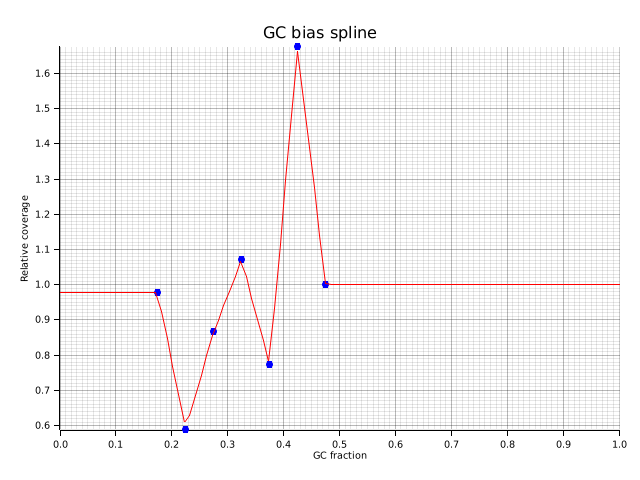

In [7]:

# Display GC-bias spline plot
from IPython.display import Image
Image('gc_bias.png')
